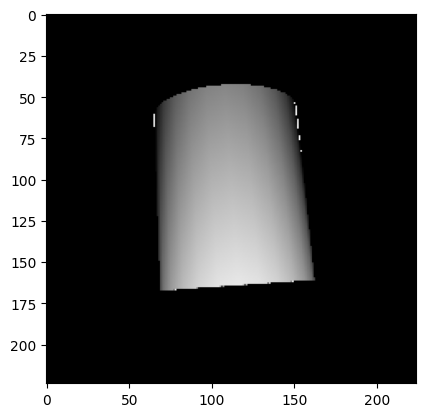

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

images_np = np.load("../../noisy_unpaired/forward_context_noisy_unpaired_data.npy")
plt.imshow(images_np[0, 2:].reshape(224, 224), cmap='gray')

In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np

# Step 1: Prepare your data
# Let's create a dummy numpy array that matches your description.
# In your actual code, you would load your own data here.

images_forward_unpaired = np.load("../../noisy_unpaired/forward_context_noisy_unpaired_data.npy")
images_inverse_unpaired = np.load("../../noisy_unpaired/inverse_context_noisy_unpaired_data.npy")
images_extra = np.load("../context_extra_data.npy")
images_test = np.load("../context_test_data.npy")
images_np = np.concatenate((images_forward_unpaired[:, 1:], images_inverse_unpaired[:, 1:], images_extra, images_test), axis=0)
images_np = images_np[:, 1:].reshape(-1, 224, 224)  # Assuming images are grayscale and reshaped to (N, 1, 224, 224)

# Step 2: Define the preprocessing pipeline
# ResNet50 was trained on 3-channel RGB images of size 224x224.
# We need to transform our grayscale 200x200 images to match this.
print("2. Defining preprocessing pipeline...")

# These are the standard ImageNet normalization values
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

preprocess_pipeline = transforms.Compose([
    # Convert a NumPy array to a PIL Image, as many transforms work with PIL
    transforms.ToPILImage(),
    
    # Convert the PIL image to a tensor. This scales pixel values to [0.0, 1.0]
    transforms.ToTensor(),
    
    # --- Crucial step for grayscale images ---
    # ResNet50 expects 3 channels. We duplicate the grayscale channel 3 times.
    # The tensor is now shape (1, 224, 224), we make it (3, 224, 224)
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    
    # Normalize with ImageNet's mean and standard deviation
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])
print("Preprocessing pipeline created successfully.")
print("-" * 30)


# Step 3: Load the pretrained ResNet50 model
print("3. Loading pretrained ResNet50 model...")
# Use the recommended modern way of loading weights
weights = models.ResNet50_Weights.IMAGENET1K_V2
model = models.resnet50(weights=weights)

# To use the model for feature extraction, we remove the final fully connected layer (the classifier)
# The output will be the 2048-dimensional feature vector from the 'avgpool' layer
feature_extractor = nn.Sequential(*list(model.children())[:-1])
print("ResNet50 model loaded and modified for feature extraction.")
print("-" * 30)


# Step 4: Set up device (GPU or CPU) and put the model in evaluation mode
print("4. Setting up device and model mode...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_extractor.to(device)
# Set the model to evaluation mode. This is important as it disables layers like Dropout
# and uses the learned running statistics for BatchNorm layers.
feature_extractor.eval()
print(f"Using device: {device}")
print("-" * 30)


# Step 5: Extract features from your images
print("5. Extracting features...")
all_features = []
num_images= 60
# Disable gradient calculations for inference, which saves memory and computation
with torch.no_grad():
    for i, img_np in enumerate(images_np):
        # Apply the preprocessing pipeline to the single numpy image
        # This will return a tensor of shape (3, 224, 224)
        input_tensor = preprocess_pipeline(img_np)
        
        # The model expects a batch of images, so we add a batch dimension
        # Shape becomes (1, 3, 224, 224)
        input_batch = input_tensor.unsqueeze(0)
        
        # Move the batch to the device
        input_batch = input_batch.to(device)
        
        # Get the feature vector from the model
        features = feature_extractor(input_batch)
        
        # The output of the feature extractor is of shape (1, 2048, 1, 1).
        # We squeeze it to get a 1D vector of shape (2048).
        features_squeezed = torch.squeeze(features)
        
        # Move features to CPU and convert to numpy if needed later, or just store the tensor
        all_features.append(features_squeezed.cpu()) # .numpy() if you need numpy array
        
        if (i + 1) % 10 == 0:
            print(f"Processed {i+1}/{num_images} images...")

# Stack all feature tensors into a single tensor
# This will be a tensor of shape (60, 2048)
final_features_tensor = torch.stack(all_features)

features_np = final_features_tensor.numpy()  # Convert to numpy array if needed
np.save("context_pretrained_features.npy", features_np)

print("\nFeature extraction complete!")
print("-" * 30)
print(f"Shape of the final features tensor: {final_features_tensor.shape}")
print("First 5 features of the first image:")
print(final_features_tensor[0, :])

2. Defining preprocessing pipeline...
Preprocessing pipeline created successfully.
------------------------------
3. Loading pretrained ResNet50 model...
ResNet50 model loaded and modified for feature extraction.
------------------------------
4. Setting up device and model mode...
Using device: cpu
------------------------------
5. Extracting features...
Processed 10/60 images...
Processed 20/60 images...
Processed 30/60 images...
Processed 40/60 images...
Processed 50/60 images...
Processed 60/60 images...
Processed 70/60 images...
Processed 80/60 images...
Processed 90/60 images...
Processed 100/60 images...
Processed 110/60 images...
Processed 120/60 images...
Processed 130/60 images...
Processed 140/60 images...
Processed 150/60 images...
Processed 160/60 images...
Processed 170/60 images...

Feature extraction complete!
------------------------------
Shape of the final features tensor: torch.Size([170, 2048])
First 5 features of the first image:
tensor([0.0310, 0.0198, 0.0230,  .

In [3]:
from sklearn.decomposition import PCA
import numpy as np

print(f"Original features shape: {final_features_tensor.shape}")

# Convert tensor to numpy array for scikit-learn
features_np = final_features_tensor.numpy()

# Split the data into training (first 60) and test (remaining 30) sets
train_features_np = features_np[60:140]

# pca = PCA(n_components=target_dimension)
pca = PCA(n_components=75)

# Fit PCA on the training data only. [1, 2]
pca.fit(train_features_np)

# Apply the transformation to both training and test sets. [1]
lower_dim_forward_unpaired = pca.transform(features_np[:60])
lower_dim_inverse_unpaired = pca.transform(features_np[60:120])
lower_dim_extra = pca.transform(features_np[120:140])
lower_dim_test = pca.transform(features_np[140:])

print("PCA complete!")
print(f"Shape of the new lower-dimensional training features: {lower_dim_forward_unpaired.shape}")

# Check how much variance is explained by the components from the training data
explained_variance = np.sum(pca.explained_variance_ratio_)
print(f"Components explain {explained_variance:.2%} of the variance in the training data.")

Original features shape: torch.Size([170, 2048])
PCA complete!
Shape of the new lower-dimensional training features: (60, 75)
Components explain 99.95% of the variance in the training data.


In [4]:
np.save("forward_context_pretrained_features_lower_train_dim75.npy", np.concatenate((lower_dim_forward_unpaired, lower_dim_extra), axis=0))
np.save("inverse_context_pretrained_features_lower_train_dim75.npy", np.concatenate((lower_dim_inverse_unpaired, lower_dim_extra), axis=0))
np.save("context_pretrained_features_lower_test_dim75.npy", lower_dim_test)